In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import InterpolatedUnivariateSpline as spline

from src.hbtp.HBTReader import HBTReader
from src import read
from src import cosmology
from src import nfw

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

### Analysis parameters

- `z = 1`
- bin `7` out of `10`

In [2]:
snap = 51
nbins = 10
bin = 7
r = HBTReader("./data/")

### Subhalo mass function

In [3]:
ss = r.LoadSubhalos(snap)
ss = ss[(ss['HostHaloId'] != -1) & (ss['BoundM200Crit'] > 0.0)& (ss['Nbound'] >= 20)]

In [4]:
counts, bin_edges = np.histogram(np.log10(ss['Nbound']), 20)
ss = np.lib.recfunctions.append_fields(ss, 'bin',\
    np.digitize(np.log10(ss['BoundM200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print counts, bin_edges, bins

[37252 29620 23602 17199 11913  7699  4733  2862  1694  1001   559   291
   145    90    39    25     9     4     0     1] [ 1.30103     1.4911247   1.68121939  1.87131409  2.06140879  2.25150349
  2.44159819  2.63169289  2.82178759  3.01188229  3.20197699  3.39207169
  3.58216639  3.77226109  3.96235579  4.15245049  4.34254519  4.53263988
  4.72273458  4.91282928  5.10292398] [ 1.39607735  1.58617204  1.77626674  1.96636144  2.15645614  2.34655084
  2.53664554  2.72674024  2.91683494  3.10692964  3.29702434  3.48711904
  3.67721374  3.86730844  4.05740314  4.24749784  4.43759253  4.62768723
  4.81778193  5.00787663]


/cosma/home/dp004/dc-oles1/merger_trees/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


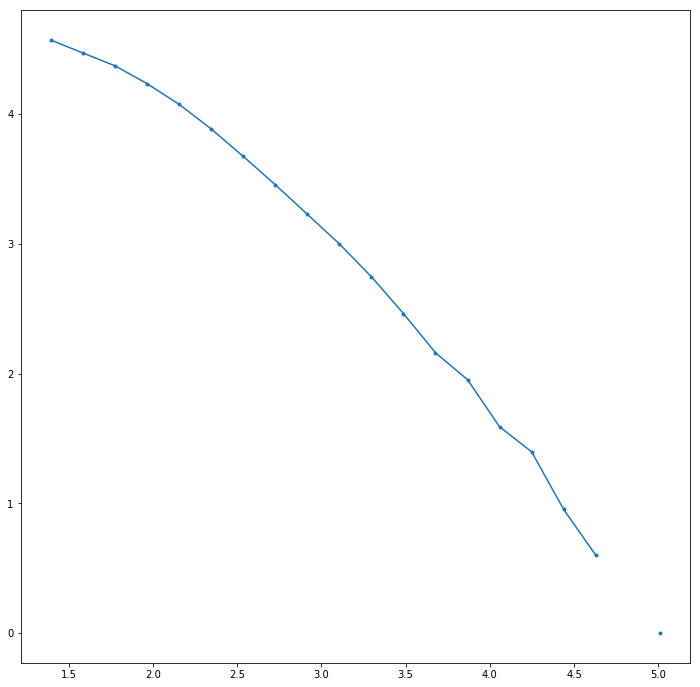

In [5]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')

### Halo mass function

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [6]:
hs = r.LoadHostHalos(snap)[['HaloId','R200CritComoving','M200Crit']]
hs = hs[hs['M200Crit'] >= 20]
hs['M200Crit'] = 1e10*hs['M200Crit']

In [7]:
counts, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
hs = np.lib.recfunctions.append_fields(hs, 'bin',\
    np.digitize(np.log10(hs['M200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print counts, bin_edges, bins

[754 411 193 114  53  33  13   4   1   1] [ 11.30166912  11.51138258  11.72109604  11.9308095   12.14052296
  12.35023642  12.55994987  12.76966333  12.97937679  13.18909025
  13.39880371] [ 11.40652585  11.61623931  11.82595277  12.03566623  12.24537969
  12.45509315  12.6648066   12.87452006  13.08423352  13.29394698]


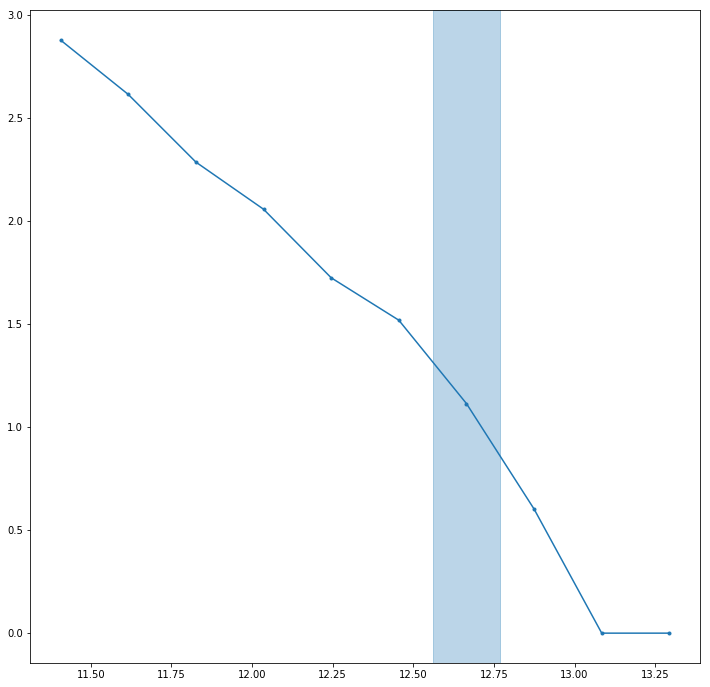

In [8]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')
plt.axvspan(bin_edges[bin-1], bin_edges[bin], color='C0', alpha=0.3)

In [9]:
hs = hs[hs['bin'] == bin]

### Density profile

In [10]:
ps = np.array(r.LoadHostHalos(snap, [list(hs['HaloId']),])['Profile'],\
    dtype=np.float)
xmin = 0.5*np.cbrt((4.0*np.pi)/(3.0*np.sum(np.mean(ps, axis=0))))
ps = np.divide(ps.T, np.sum(ps, axis=1)).T
p = np.mean(ps, axis=0)
x = np.linspace(-2.0, 0.0, 20)
# vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))

In [11]:
xmax = 0.8
idx = np.where((np.power(10,x) < xmax) & (np.power(10,x) > xmin))
c = nfw.fit(p, lambda c: nfw.m(np.power(10.0,x), c), np.linspace(1.0, 10.0, 100))
rho_s = np.log10(nfw.rho_enc(1.0/c, c))

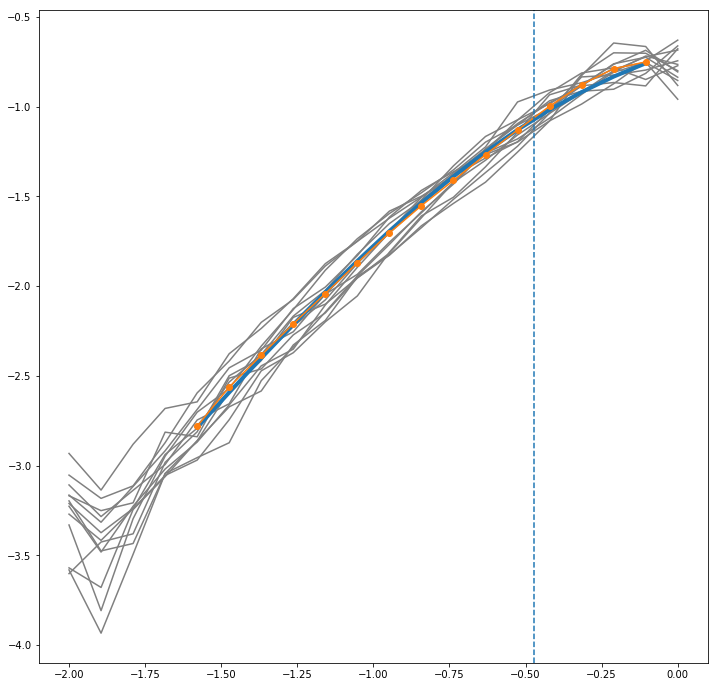

In [12]:
# plt.fill_between(x,\
#     np.log10(nfw.m_diff(np.power(10.,x), c_err[0])),\
#     np.log10(nfw.m_diff(np.power(10.,x), c_err[1])),
#     color='C0', alpha=0.2, zorder=1)
plt.plot(x[idx], np.log10(nfw.m(np.power(10.,x), c)[idx]),\
    color='C0', linewidth=4, zorder=1)

[plt.plot(x, np.log10(_), color='grey', zorder=0) for _ in ps]
plt.plot(x[idx], np.log10(p[idx]), color='C1', marker='o', zorder=2)
plt.axvline(np.log10(1.0/c), color='C0', linestyle='--')

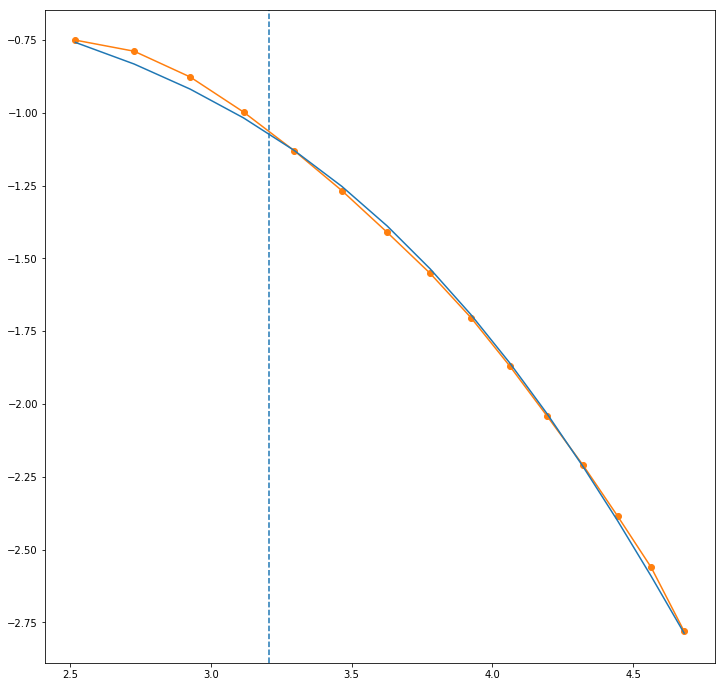

In [13]:
plt.plot(np.log10(nfw.rho_enc(np.power(10.,x), c)[idx]), np.log10(p[idx]),\
    color='C1', marker='o')
plt.plot(np.log10(nfw.rho_enc(np.power(10.,x), c)[idx]), np.log10(nfw.m(np.power(10.,x), c)[idx]),\
    color='C0')
plt.axvline(rho_s, color='C0', linestyle='--')

### Collapsed Mass History

In [14]:
F = nfw.Y(1.0)/nfw.Y(c)

In [15]:
ms = np.array(read.cmh(snap).loc[hs['HaloId']], dtype=np.float)
ms = np.divide(ms.T, ms[:,-1]).T
m = np.mean(ms, axis=0)

zs = np.genfromtxt('./output/hbtp/redshift_list.txt',\
    dtype=np.dtype([('snapshot',np.int32), ('redshift',np.float32)]))
rho = cosmology.rho_c(\
    np.array([zs[zs['snapshot'] == s][0]['redshift']\
    for s in np.arange(1+snap-ms.shape[1], 1+snap)]))\
    / cosmology.rho_c(zs[zs['snapshot'] == snap][0]['redshift'])

In [16]:
m_f = F*m[-1]
y1, y2 = m[m > m_f][0], m[m < m_f][-1]
x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
rho_f = (np.log10(x1/x2)/np.log10(y1/y2))*(np.log10(m_f/y1))+np.log10(x1)

/cosma/home/dp004/dc-oles1/merger_trees/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/cosma/home/dp004/dc-oles1/merger_trees/env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


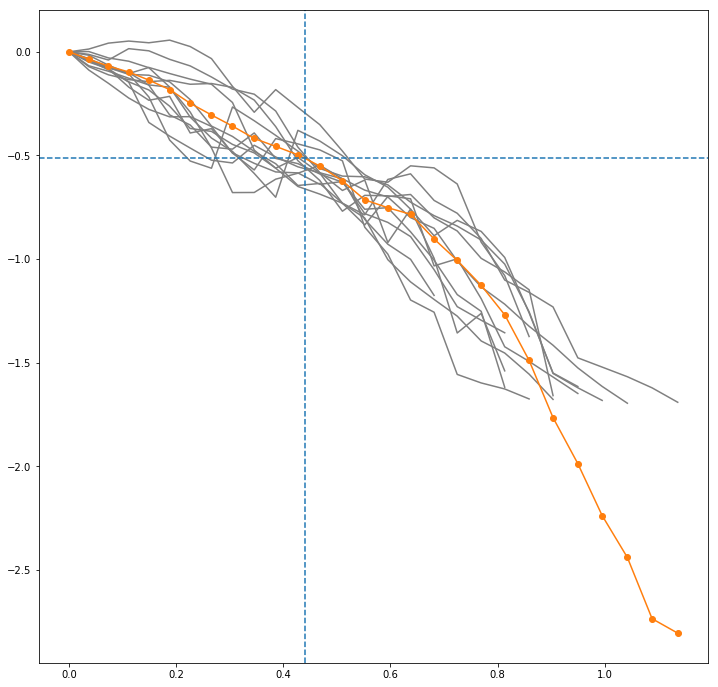

In [17]:
[plt.plot(np.log10(rho), np.log10(_), color='grey') for _ in ms]
plt.plot(np.log10(rho), np.log10(m),\
    color='C1', marker='o')
plt.axhline(np.log10(m_f), color='C0', linestyle='--')
plt.axvline(rho_f, color='C0', linestyle='--')

In [18]:
print rho_s, rho_f

3.2063136973 0.440368642938
